# Test

## なにをするのか

Modelが意図した通りに構築されているか、インプット、プロセス、アウトプットの観点から評価しTest Reportを作成します。Test Reportには、Business goalを達成できているかの評価を含めます。

## なぜやるのか

通常のソフトウェア開発と同様、機械学習モデルも品質を担保するためにテストを行う必要があります。また、プロジェクトを先に進めるかどうかの意思決定を行うために、ステークホルダーとともに学習した機械学習モデルでBusiness goalが達成できるか検証する必要があります。

## どうやるのか

機械学習モデルの品質は、3つの観点からテストが必要です。インプットとプロセスは通常のプログラムであるため、既存のソフトウェアテスト手法(単体テストなど)でテストができます。そのため、演習は3のアウトプットのテストにフォーカスします。プログラミング演習ではモデルの性能とモデルの頑健性、コミュニケーション演習で機械学習システム全体の評価を行うための質問を作成します。

1. インプット
   * 入力データの質と量
2. プロセス
   * データの学習・加工プロセス
3. **アウトプット**
   * モデルの性能
   * モデルの頑健性
   * 機械学習システム全体の評価

### プログラミング演習

#### モデルの性能

モデルの性能を評価する指標は、どのようなモデルかによって異なります。今回は価格を予測する回帰の問題であるため、**二乗平均平方根誤差(RMSE)** を用います。数式で定義すると次式になります。数式が出てくるとちょっと・・・という方もいらっしゃると思いますが、予測した値と実際の値との差の平均というイメージで問題ありません。

![test_001.PNG](images/06_test_001.PNG)
*$y_i$が実際の値、$\hat{y}_i$が予測値、$n$がデータ数になります。*

RMSEを計測してみましょう。はじめにテスト用のデータ、前処理用のエンコーダーを読み込みます。

In [1]:
from pathlib import Path
import pandas as pd


test_data_path = Path("../data/interim/test.csv")
test_df = pd.read_csv(test_data_path)

In [2]:
from pathlib import Path
from joblib import load


encoder = load(Path("../model/encoder.joblib"))

モデルを読み込みます。

In [3]:
model = load(Path("../model/model.joblib")) 
other_model = load(Path("../model/other_model.joblib"))  

評価では何度も予測を行うため、予測を行うための関数を準備しておきます。

In [4]:
def predict(test_df, model, prediction_name="SalePricePredicted"):
    preprocessed = encoder.transform(test_df)
    preprocessed_df = pd.DataFrame(preprocessed, columns=test_df.columns)
    preprocessed_df = preprocessed_df.fillna(preprocessed_df.median())
    
    X = preprocessed_df.drop("SalePrice", axis=1)
    y = preprocessed_df["SalePrice"]

    prediction = model.predict(X)
    
    # 予測されるのは標準化された予測値なので、元に戻す
    inversed_y = encoder.named_transformers_["standardscaler-2"].inverse_transform(prediction.reshape((-1, 1)))
    
    prediction_df = pd.concat([
        test_df, pd.DataFrame(inversed_y, columns=[prediction_name]),
    ], axis=1)

    return prediction_df

関数を使い、予測を行ってみます。

In [5]:
prediction_df = predict(test_df, model)
prediction_df

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,MasVnrType,Neighborhood,PavedDrive,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,SalePricePredicted
0,504,20,100.0,15602,7,8,1959,1997,0.0,1247,...,None,Crawfor,Y,CompShg,Gable,Normal,WD,Pave,AllPub,170767.080245
1,830,160,24.0,2544,7,5,2005,2005,0.0,0,...,None,Somerst,Y,CompShg,Gable,Normal,WD,Pave,AllPub,188888.130328
2,113,60,77.0,9965,7,5,2007,2007,220.0,984,...,Stone,CollgCr,Y,CompShg,Gable,Partial,New,Pave,AllPub,215004.276967
3,156,50,60.0,9600,6,5,1924,1950,0.0,0,...,None,Edwards,N,CompShg,Gable,Normal,WD,Pave,AllPub,134932.231506
4,271,60,84.0,10728,8,5,2006,2006,0.0,0,...,None,Somerst,Y,CompShg,Gable,Partial,New,Pave,AllPub,227634.260601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,141,20,70.0,10500,4,5,1971,1971,0.0,432,...,None,NAmes,Y,CompShg,Gable,Normal,ConLI,Pave,AllPub,127549.480375
434,861,50,55.0,7642,7,8,1918,1998,0.0,0,...,None,Crawfor,Y,CompShg,Gable,Normal,WD,Pave,AllPub,150988.612723
435,1096,20,78.0,9317,6,5,2006,2006,0.0,24,...,None,CollgCr,Y,CompShg,Gable,Normal,WD,Pave,AllPub,178451.386010
436,624,160,NaN,2117,6,5,2000,2000,513.0,420,...,BrkFace,Somerst,Y,CompShg,Gable,Normal,WD,Pave,AllPub,185886.393223


モデルの性能を計測しましょう。`squared=False`にすることで平方根を取ったRMSEが得られます。

In [6]:
from sklearn.metrics import mean_squared_error


rmse = mean_squared_error(prediction_df["SalePrice"], prediction_df["SalePricePredicted"], squared=False)
print(f"Mean squared error {rmse}")

Mean squared error 58614.29200356144


住宅の価格が100,000ドル~と考えると、RMSEはそこそこの値と見えます。予測の分布を比較してみると、元の値と大体同じ分布になっていることがわかります。

<AxesSubplot:ylabel='Frequency'>

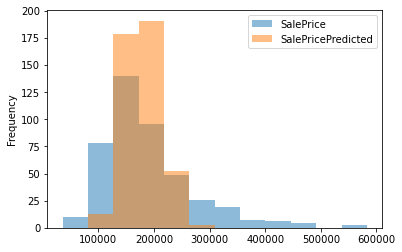

In [7]:
pd.concat([prediction_df["SalePrice"], prediction_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

*Exercise: もう片方のモデルでも性能を計測してみましょう*

In [8]:
prediction_other_df = predict(test_df, other_model)
rmse = mean_squared_error(prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"], squared=False)
print(f"Mean squared error {rmse}")

Mean squared error 58614.29200356144


<AxesSubplot:ylabel='Frequency'>

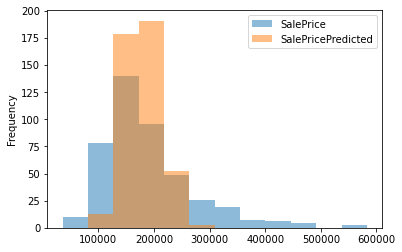

In [9]:
pd.concat([prediction_other_df["SalePrice"], prediction_other_df["SalePricePredicted"]], axis=1).plot.hist(bins=12, alpha=0.5)

#### モデルの頑健性

モデルの予測が入力値に応じて大きく変動してしまわないかは、実際使用するうえで重要です。
入力の変化に応じた出力の変化が起きているかでモデルの頑健性を評価する手法をメタモルフィックテストと呼びます。モデルの出力が予測の範囲内に収まるかどうかを検証するのに有効なテストです。

特徴として最も顕著に効いている`OverallQual`を変化させたときにどのように予測が変わるか検証してみましょう。

In [10]:
def metamorphic_test(df, model, column, factor=1.0):
    _df = df.copy()
    _df[column] = _df[column] * factor
    _df = predict(_df, model)
    compare_df = pd.concat([prediction_df["SalePrice"], _df["SalePricePredicted"]], axis=1)
    return compare_df.plot.hist(bins=12, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

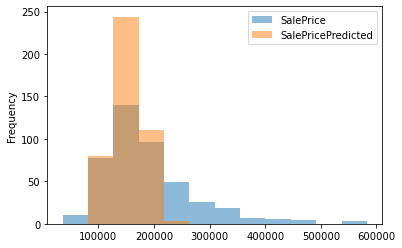

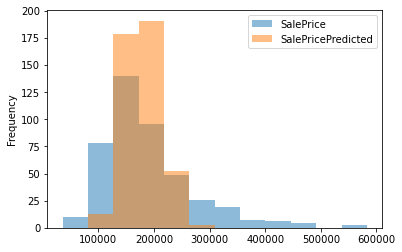

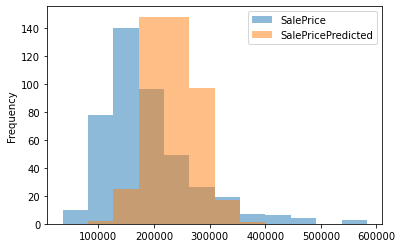

In [11]:
metamorphic_test(test_df, model, "OverallQual", 0.5)
metamorphic_test(test_df, model, "OverallQual", 1.0)
metamorphic_test(test_df, model, "OverallQual", 2.0)

価格の分布が大きくずれていることがわかります。

モデルの性能と頑健性が、Business goalのうち機械学習モデルの担当分であるModel Usage Impactの達成に十分であるかを、コミュニケーション演習で確認しましょう。

### コミュニケーション演習

データサイエンティストとして、モデルの性能と頑健性についてレポートを作成しました。誰にどのような質問をすべきでしょうか。


| 英語名             | 日本語名                   | 役割                                                                 |
|--------------------|----------------------------|----------------------------------------------------------------------|
| Product Manager    | プロダクトマネージャー     | ユーザー体験を向上させるために実装すべきソフトウェア機能を定義する。 |
| Business Analyst   | ビジネスアナリスト         | 解決すべきビジネス上の問題を定義する                                 |
| Data Analyst       | データアナリスト           | データの可視化と分析で問題を定量的に特定する。                       |
| Architect          | アーキテクト               | ソフトウェアアーキテクチャ全体を設計する。                           |
| DevOps Engineer    | DevOpsエンジニア           | ソフトウェアの開発・運用プロセスを自動化する。                       |
| Software Engineer  | ソフトウェアエンジニア     | ソフトウェアの開発を行う。                                           |
| Operator           | 業務担当者                 | ソフトウェアを利用し業務を行う。                                     |
| System Admin       | システム管理者             | サービスの挙動を監視する。                                           |
| IT Auditor         | IT監督者                   | システムや会社全体の権限管理や監査を行う。                           |
| Data architect     | データアーキテクト         | データを管理する基盤を設計、運用する。                               |
| Domain Expert      | 業務有識者                 | 深い業務知識を持ちデータの意味やあるべき状態について定義する。       |
| Data Engineer      | データエンジニア           | 機械学習モデルに入力可能なデータと特徴を作成する。                   |
| Data Scientist     | データサイエンティスト     | 機械学習モデルを開発する。                                           |
| ML Engineer        | 機械学習エンジニア         | 機械学習モデルを本番環境にデプロイ可能な形式に変換する。             |
| ML Operator        | 業務担当者(機械学習側)     | 推論結果に基づき業務を行いつつ、フィードバックを与える。             |
| Model risk Manager | 機械学習モデルリスク管理者 | 機械学習モデルの推論の挙動を監視する。                               |
| MLOps Engineer     | MLOpsエンジニア            | 機械学習モデルの開発・運用プロセスを自動化する。                     |
| AI/ML Architect    | AI/MLアーキテクト          | 機械学習モデル開発に必要なアーキテクチャ全体を設計する。             |

#### 質問例

* Domain Expert
   * 業務上頻繁なケースについて、機械学習モデルの予測はどれぐらい利用できますか?(100%、80%、50%、20%など)
   * 予測を使うことで価格を設定する時間はどの程度下がりますか。
* Product Manager
   * 機械学習モデルをリリースしていくために、追加で検証すべきシナリオや合意しておくべきステークホルダーはいますか。

## Next Step

[おわりに](../docs/ending.md)

## References

1. 佐藤直人, 小川秀人, 來間啓伸 and 明神智之. [AIソフトウェアのテスト](https://www.amazon.co.jp/dp/B095W5VGB3/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1). 2021.

関連するAWSのサービス

1. Model Monitor
2. SageMaker Model Registry
